In [1]:
import requests
import sys
from tqdm import tqdm

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad

Read the matrices:

In [2]:
adata = sc.read_mtx("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/E-GEOD-81547-quantification-raw-files/E-GEOD-81547.aggregated_filtered_counts.mtx").T

cell_ids = pd.read_csv("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/E-GEOD-81547-quantification-raw-files/E-GEOD-81547.aggregated_filtered_counts.mtx_cols", index_col=None, header=None)

gene_ids = pd.read_csv("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/E-GEOD-81547-quantification-raw-files/E-GEOD-81547.aggregated_filtered_counts.mtx_rows", index_col=None, header=None, sep="\t")[0]

adata.obs.index = cell_ids[0]
adata.var.index = gene_ids

In [3]:
obs = pd.read_csv("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/E-GEOD-81547-experiment-metadata-files/E-GEOD-81547.sdrf.txt", sep="\t")

obs["age"] = obs["Characteristics [age]"].astype(str) + obs["Unit[time unit]"]

keep = obs["Scan Name"].str.contains("2.fastq.gz")

Subset the cell metadata to only keep (potentially) relevant columns:

In [4]:
subset = obs[["Comment [ENA_RUN]",
             "Characteristics[individual]",
             "age",
             "Characteristics [sex]",
             "Factor Value [inferred cell type - ontology labels]",
             "Characteristics[disease]",
             "Characteristics[body mass index]",
             "Characteristics[cause of death]"]]

subset = subset[keep].set_index("Comment [ENA_RUN]").copy()

In [5]:
tmp = adata.obs.join(subset)

tmp.index.name = "Index"

adata.obs = tmp.copy()

In [6]:
adata.obs

,Characteristics[individual],age,Characteristics [sex],Factor Value [inferred cell type - ontology labels],Characteristics[disease],Characteristics[body mass index],Characteristics[cause of death]
Index,,,,,,,
SRR3562210,DID_scRSq04,21year,male,pancreatic A cell,normal,28.4,anoxia
SRR3562211,DID_scRSq04,21year,male,pancreatic A cell,normal,28.4,anoxia
SRR3562212,DID_scRSq04,21year,male,acinar cell,normal,28.4,anoxia
SRR3562213,DID_scRSq04,21year,male,pancreatic A cell,normal,28.4,anoxia
SRR3562214,DID_scRSq04,21year,male,pancreatic A cell,normal,28.4,anoxia
...,...,...,...,...,...,...,...
SRR3564749,DID_scRSq05,22year,male,NaN,normal,24.8,head trauma
SRR3564750,DID_scRSq05,22year,male,type B pancreatic cell,normal,24.8,head trauma
SRR3564751,DID_scRSq05,22year,male,mesenchymal cell,normal,24.8,head trauma


Submit to the ENSEMBL API:

In [7]:
def get_gene_names(gene_ids):
  genes = '", "'.join(gene_ids)
  data = '{ "ids" : ["' + genes + '" ] }'
  
  server = "https://rest.ensembl.org"
  ext = "/lookup/id"
  headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
  
  r = requests.post(server+ext, headers=headers, data=data)
  
  if not r.ok:
    r.raise_for_status()
    sys.exit()
  
  decoded = r.json()
  return decoded

In [8]:
def decode_gene_names(decoded):
    gene_names = {}
    for gene in decoded.values():
        try:
            gene_id = gene["id"]
            gene_symbol = gene.get("display_name", "")
            gene_names[gene_id] = gene_symbol
        except TypeError:
            continue
    return gene_names

Actually translate names:

In [9]:
step = 1000
for i in tqdm(range(0, adata.shape[1], step)):
    gene_ids = adata.var.index[i:i+step]
    decoded = get_gene_names(gene_ids)
    gene_names = decode_gene_names(decoded)
    adata.var.loc[gene_ids, "gene_names"] = pd.Series(gene_names)

100%|██████████| 31/31 [08:14<00:00, 15.97s/it]


In [10]:
adata.var["gene_names"].fillna(adata.var.index.to_series(), inplace=True)

In [11]:
mito = adata.var["gene_names"].str.startswith("MT-")
adata.var["mitochondrial"] = mito

In [12]:
ribo = ["RPSA", "RPS2", "RPS3", "RPS3A", "RPS4X", "RPS4Y", "RPS5c", "RPS6", "RPS7", "RPS8", "RPS9",
"RPS10", "RPS11", "RPS12", "RPS13", "RPS14", "RPS15", "RPS15A", "RPS16", "RPS17", "RPS18",
"RPS19", "RPS20", "RPS21", "RPS23", "RPS24", "RPS25"]

In [13]:
adata.var["ribosomal"] = adata.var["gene_names"].isin(ribo)

In [14]:
adata.obs["mtdna"] = np.sum(adata.X[:, adata.var["mitochondrial"]], axis=1) / np.sum(adata.X, axis=1)
adata.obs["rrna"] = np.sum(adata.X[:, adata.var["ribosomal"]], axis=1) / np.sum(adata.X, axis=1)

In [15]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [16]:
adata.obs

,Characteristics[individual],age,Characteristics [sex],Factor Value [inferred cell type - ontology labels],Characteristics[disease],Characteristics[body mass index],Characteristics[cause of death],mtdna,rrna,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
Index,,,,,,,,,,,,,,,,,
SRR3562210,DID_scRSq04,21year,male,pancreatic A cell,normal,28.4,anoxia,0.078379,0.005085,6256,8.741456,702279.00000,13.462088,27.772616,34.095080,43.120790,61.170132
SRR3562211,DID_scRSq04,21year,male,pancreatic A cell,normal,28.4,anoxia,0.088145,0.002019,6224,8.736329,700124.68750,13.459015,40.542128,46.172627,54.306400,69.667084
SRR3562212,DID_scRSq04,21year,male,acinar cell,normal,28.4,anoxia,0.067149,0.007779,5116,8.540324,286937.00000,12.567021,37.545244,44.416439,53.636373,70.960653
SRR3562213,DID_scRSq04,21year,male,pancreatic A cell,normal,28.4,anoxia,0.073523,0.003406,7341,8.901367,490782.96875,13.103760,33.029235,38.362183,46.233524,62.133353
SRR3562214,DID_scRSq04,21year,male,pancreatic A cell,normal,28.4,anoxia,0.077596,0.002325,4583,8.430327,538627.00000,13.196780,39.194300,48.151760,59.427069,76.558487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3564749,DID_scRSq05,22year,male,NaN,normal,24.8,head trauma,0.046293,0.005364,1543,7.342132,554163.00000,13.225216,50.623271,62.172637,77.000269,95.273367
SRR3564750,DID_scRSq05,22year,male,type B pancreatic cell,normal,24.8,head trauma,0.253500,0.002664,5314,8.578288,672545.00000,13.418826,65.405499,68.804014,73.243093,82.198912
SRR3564751,DID_scRSq05,22year,male,mesenchymal cell,normal,24.8,head trauma,0.012910,0.006243,5378,8.590258,532936.00000,13.186158,47.218358,53.437489,60.383951,72.198594


In [17]:
adata.var.index.name = "Index"

In [18]:
adata.write_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/raw_pancreas.h5ad")

In [19]:
adata = sc.read("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/raw_pancreas.h5ad")

In [20]:
# create the normalized matrix that I'll use for the dimensionality reduction and clustering
proportional_fitting = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1pPF_normalization"] = sc.pp.log1p(proportional_fitting["X"])
# proportional fitting
adata.layers["PFlog1pPF"] = sc.pp.normalize_total(adata, target_sum=None, layer="log1pPF_normalization", inplace=False)["X"]

In [21]:
adata.raw = adata

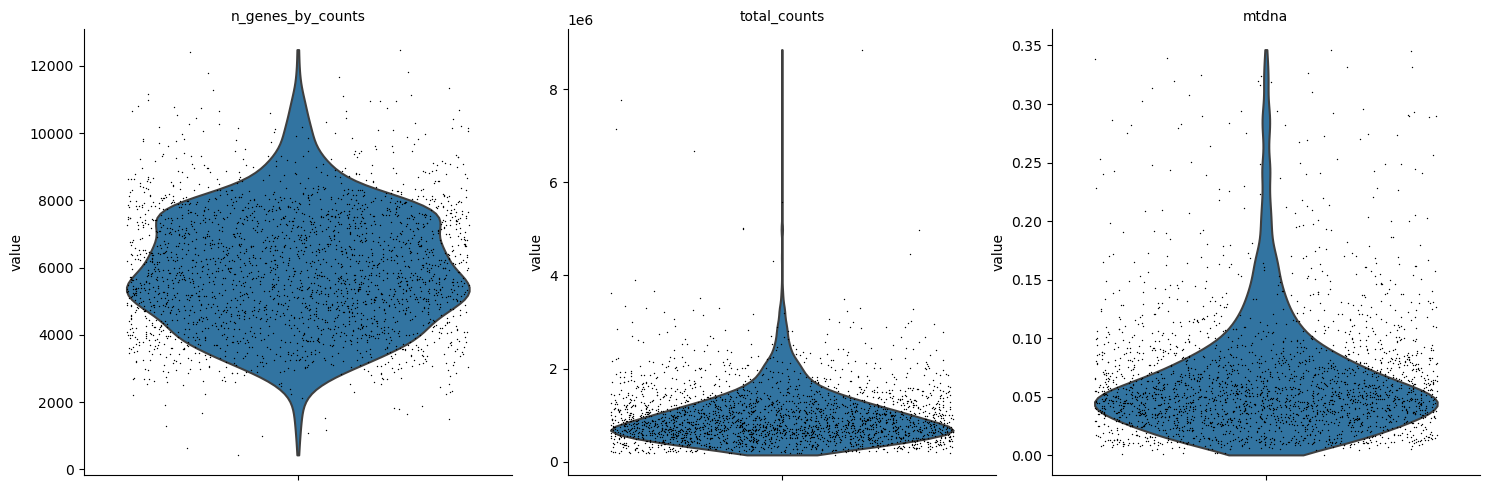

In [22]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'mtdna'],
             jitter=0.4, multi_panel=True)

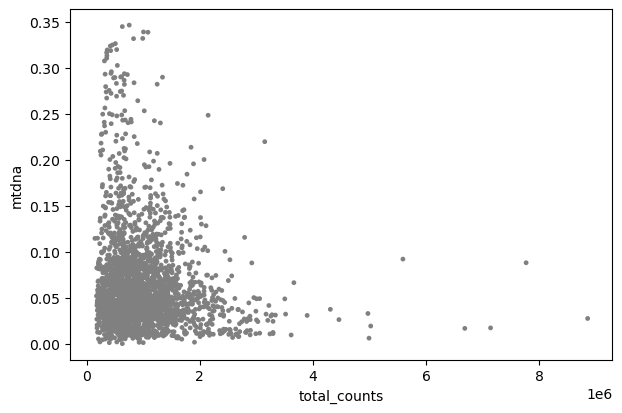

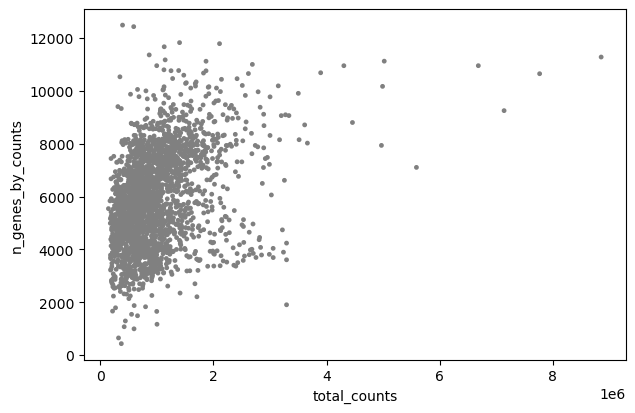

In [23]:
sc.pl.scatter(adata, x='total_counts', y='mtdna')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Keep the usual normalisation in the `.X` slot so we don't upset the scanpy internals:

In [24]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

...but calculate the PCA from the well-normalised matrix:

In [25]:
mat = adata.layers["PFlog1pPF"][:, adata.var["highly_variable"]].copy()
adata.obsm["X_pca"] = sc.tl.pca(mat, svd_solver="arpack", n_comps=50)

In [26]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=10, metric="cosine")

/Users/npapadop/mambaforge/envs/liger/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
sc.tl.umap(adata, min_dist=0.5)

/Users/npapadop/mambaforge/envs/liger/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


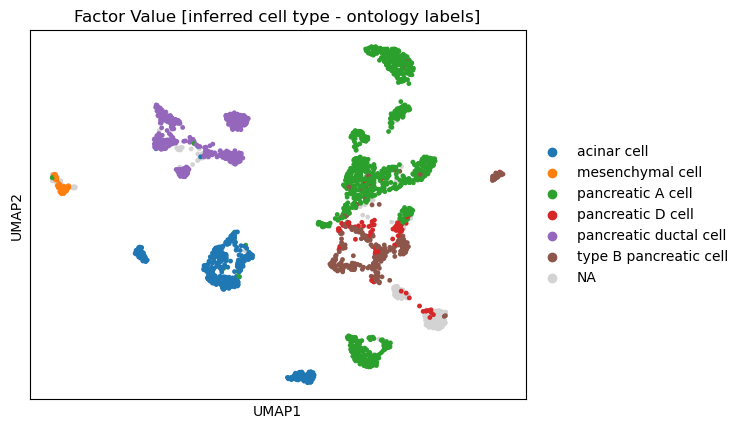

In [28]:
sc.pl.umap(adata, color="Factor Value [inferred cell type - ontology labels]")

/Users/npapadop/mambaforge/envs/liger/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


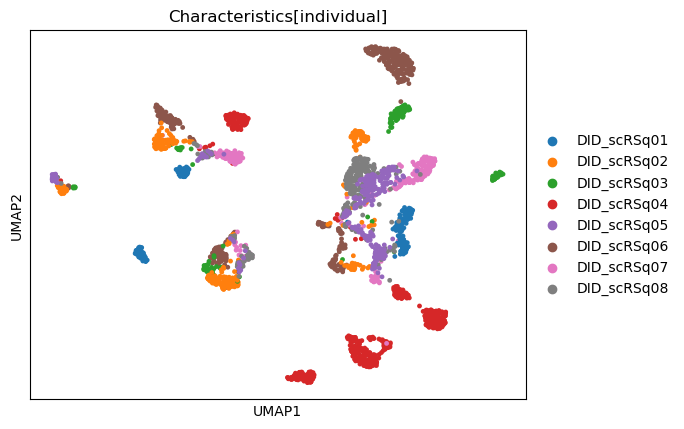

In [29]:
sc.pl.umap(adata, color="Characteristics[individual]")

In [33]:
import pyliger

In [36]:
def split_anndata(adata, split_by):
    """
    Split anndata object into a dictionary of anndata objects based on a categorical variable.

    Parameters
    ----------
    adata : ad.AnnData
        The input anndata object.
    split_by : str
        A categorical variable in adata.obs.

    Returns
    -------
    dict
        A dictionary of anndata objects, each corresponding to a category of the split_by variable.
    """
    adata_dict = {}
    for value in adata.obs[split_by].unique():
        keep = adata.obs[split_by] == value
        adata_dict[value] = adata[keep].copy()
    return adata_dict

In [37]:
patient_adata = split_anndata(adata, "Characteristics[individual]")

dict_items([('DID_scRSq04', AnnData object with n_obs × n_vars = 503 × 30751
    obs: 'Characteristics[individual]', 'age', 'Characteristics [sex]', 'Factor Value [inferred cell type - ontology labels]', 'Characteristics[disease]', 'Characteristics[body mass index]', 'Characteristics[cause of death]', 'mtdna', 'rrna', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_names', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'Factor Value [inferred cell type - ontology labels]_colors', 'Characteristics[individual]_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1pPF_normalization', 'PFlog1pPF'
    obsp: 'dist

In [43]:
pyliger.create_liger(a
                     patient_adata.values)

TypeError: 'dict_values' object is not subscriptable

In [39]:
patient_adata["DID_scRSq04"]

AnnData object with n_obs × n_vars = 503 × 30751
    obs: 'Characteristics[individual]', 'age', 'Characteristics [sex]', 'Factor Value [inferred cell type - ontology labels]', 'Characteristics[disease]', 'Characteristics[body mass index]', 'Characteristics[cause of death]', 'mtdna', 'rrna', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_names', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'Factor Value [inferred cell type - ontology labels]_colors', 'Characteristics[individual]_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1pPF_normalization', 'PFlog1pPF'
    obsp: 'distances', 'connectivities'